<a href="https://colab.research.google.com/github/KelvinJais/ReadBuddy/blob/main/ReadBuddy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read Buddy Main

In [21]:
# Set bok and page number
book_path = "/content/Neil Gaiman - American Gods.pdf"
page_number=80

In [22]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph pypdf
%pip install -qU "langchain[openai]"

In [23]:
from google.colab import userdata
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = userdata.get('LANGSMITH_API')

In [24]:
import getpass
import os
from google.colab import userdata
if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4.1-nano", model_provider="openai")

In [25]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()

In [26]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_community.vectorstores import FAISS

vector_store = InMemoryVectorStore(embeddings)

In [27]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

In [28]:
from langchain_community.document_loaders import PyPDFLoader
loader = PyPDFLoader(book_path)
docs = loader.load()

In [29]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs[:page_number])
len(all_splits)

151

In [30]:
_ = vector_store.add_documents(documents=all_splits)

In [31]:
# Building Vector Search (Basic RAG)
prompt = hub.pull("rlm/rag-prompt")

# State
class State(TypedDict):
    input: str
    context: str
    decision: str
    output: str

# Define application steps for Vector Search
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["input"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["input"], "context": docs_content})
    response = llm.invoke(messages)
    return {"output": response.content}

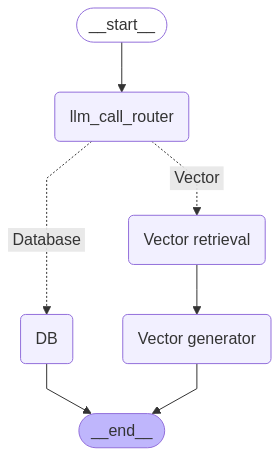

In [32]:
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, Field
from IPython.display import Image, display

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["vector", "db"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


def DB(state: State):
    """Get Pages from Database"""
    return {"output": "DB state"}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to vector search or db search. If the input question is asking about a certain character or a plot question route them to vector. If the input question asks about a summary of the last few pages then route them to db search"
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "vector":
        return "Vector"
    elif state["decision"] == "db":
        return "Database"



# Build workflow
router_builder = StateGraph(State)

# Add nodes

router_builder.add_node("DB", DB)
router_builder.add_node("llm_call_router", llm_call_router)
router_builder.add_node("Vector retrieval", retrieve)
router_builder.add_node("Vector generator", generate)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "Vector": "Vector retrieval",
        "Database": "DB",
    },
)
#Vector edges
router_builder.add_edge("Vector retrieval","Vector generator" )
router_builder.add_edge("Vector generator", END)

#DB edges
router_builder.add_edge("DB", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))


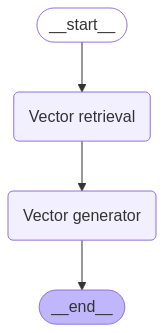

In [55]:
router_without_db=StateGraph(State)
router_without_db.add_node("Vector retrieval", retrieve)
router_without_db.add_node("Vector generator", generate)

router_without_db.add_edge(START, "Vector retrieval")
router_without_db.add_edge("Vector retrieval","Vector generator" )
router_without_db.add_edge("Vector generator", END)

router_without_db_workflow = router_without_db.compile()
display(Image(router_without_db_workflow.get_graph().draw_mermaid_png()))

In [56]:
def ReadBuddy(inputs: dict):
  state = router_without_db_workflow.invoke({"input": inputs["question"]})
  return state["output"]
  return {"answer": state["output"]}

In [57]:
state = router_without_db_workflow.invoke({"input": "What unusual dream does Shadow have on the plane?"})
print(state["output"])

Shadow dreams that he is in a dark, underground place where a buffalo-headed figure tells him that "changes are coming" and that he is "where the forgotten wait." The buffalo man’s eyes are liquid, and he speaks of decisions that must be made, creating an eerie and symbolic vision. The dream ends with the world tipping and Shadow questioning if he might die, before waking on the plane amidst a storm.


In [52]:
ReadBuddy({"question": "What unusual dream does Shadow have on the plane?"})

'Shadow dreams that he is in a dark, underground place where a buffalo-headed figure tells him that changes are coming and important decisions must be made. In the dream, the buffalo man says he is "where the forgotten wait," and his eyes are liquid and fiery. The dream then shifts to Shadow back on the plane, experiencing a storm and contemplating death.'

In [48]:
import pandas as pd

# Define the question and answer pairs as lists
inputs = [
    "What crime was Shadow convicted of, and how long did he serve in prison?",
    "How did Shadow cope with his time in prison?",
    "What were the three things Shadow planned to do after getting out of prison?",
    "Who is Laura, and what was her relationship with Shadow?",
    "How did Shadow meet Laura?",
    "Who was Robbie, and what was his connection to Shadow?",
    "What happened to Laura and Robbie?",
    "What did Shadow learn about Laura and Robbie’s relationship after their deaths?",
    "Why was Shadow released from prison early?",
    "Who is Mr. Wednesday, and how does he approach Shadow?",
    "What unusual dream does Shadow have on the plane?",
    "What is the significance of the coin Shadow receives from Mad Sweeney?",
    "What does the recurring theme of storms symbolize in the early part of the book?",
    "What does Shadow’s attitude toward belief and superstition reveal about his character?",
    "Who is Mad Sweeney, and what role does he play when Shadow meets him?",
    "What is the subplot involving Bilquis in Los Angeles?",
    "What happens during Shadow’s encounter with the mysterious young man in the limo?",
    "How does Shadow react to learning about Laura’s betrayal?",
    "What does Shadow do at Laura’s grave?"
]

outputs = [
    "Shadow was convicted of aggravated assault and battery. He was sentenced to six years but served three years in prison before being released early due to his wife's death.",
    "Shadow kept himself in shape, taught himself coin tricks, and tried to keep a low profile. He also read books, including Herodotus's Histories, and avoided unnecessary trouble.",
    "Shadow planned to take a long bath, spend time with his wife Laura, and keep his head down to stay out of trouble for the rest of his life.",
    "Laura was Shadow's wife. They had a close relationship, and Shadow thought about her often while in prison. She worked as a travel agent.",
    "Shadow met Laura on a blind date arranged by mutual friends-his best buddy's wife's best friend.",
    "Robbie was Shadow's best friend and owner of the Muscle Farm gym, where Shadow used to work. Robbie promised Shadow a job upon his release from prison.",
    "Laura and Robbie died together in a car accident just before Shadow was released from prison.",
    "Shadow learned from Audrey Burton, Robbie’s wife, that Laura and Robbie were having an affair. Laura died with Robbie during the accident, and Audrey told Shadow that Laura died with Robbie’s 'cock in her mouth'.",
    "Shadow was released early because his wife, Laura, died in a car accident.",
    "Mr. Wednesday is a mysterious man who meets Shadow on a plane and offers him a job as his bodyguard and errand boy. He seems to know a lot about Shadow and insists that Shadow has nothing left to return to.",
    "Shadow dreams of a buffalo-headed man who tells him, 'If you are to survive, you must believe,' and urges him to 'believe everything'.",
    "Mad Sweeney, who claims to be a leprechaun, gives Shadow a gold coin after a bar fight. Shadow later throws this coin into Laura’s grave during her burial.",
    "The storms foreshadow major changes and turmoil in Shadow’s life, as well as larger conflicts to come. Characters like Sam Fetisher warn Shadow about a 'big storm coming,' both literally and metaphorically.",
    "Shadow claims not to be superstitious and only believes in what he can see, yet he is repeatedly confronted with strange and supernatural events that challenge his skepticism.",
    "Mad Sweeney is a tall, bearded man who claims to be a leprechaun. He demonstrates coin tricks, fights Shadow in a bar, and gives him a gold coin.",
    "Bilquis is a goddess working as a prostitute. She consumes a client during sex after he worships her, demonstrating her supernatural powers and the theme of old gods surviving in modern America.",
    "Shadow is abducted and threatened by a fat young man in a limo, who warns him that Wednesday is 'history' and that new gods-representing modern concepts like technology-are taking over.",
    "Shadow is hurt but remains stoic. He refuses to let his pain turn into hatred for Laura, even after learning of her affair with Robbie.",
    "Shadow throws the gold coin from Mad Sweeney into Laura’s grave and says goodbye, expressing sorrow and closure."
]



In [58]:
from langsmith.evaluation import evaluate, LangChainStringEvaluator

# Evaluators
qa_evalulator = [LangChainStringEvaluator("cot_qa")]
dataset_name = "DBRX"

experiment_results = evaluate(
    ReadBuddy,
    data=dataset_name,
    evaluators=qa_evalulator,
    experiment_prefix="test-dbrx-qa-oai",
    # Any experiment metadata can be specified here
    metadata={
        "variant": "ReadBuddy evaluation",
    },
)


View the evaluation results for experiment: 'test-dbrx-qa-oai-ce0faff7' at:
https://smith.langchain.com/o/e8d53648-3cb8-416b-a448-701e2676ed67/datasets/d61bbe2d-4207-41ca-9eb0-6fff2d3074a9/compare?selectedSessions=1beae159-a407-48fb-8478-5f39fa60fb08




0it [00:00, ?it/s]